# Supplementary Source Code 5 – Growth Stage Prediction 

This Jupyter notebook describes how to predict growth stages for different wheat genotypes in relation to real-time performance trait analysis and environment data. It employs support vector machines (SVM) with radial basis function kernels to classify growth stages. The performance of the model is trained and tested by Paragon WT (G1) growth data from 2015 and 2016, which were measured by SC4-CropTraitMeasuring_PC_V1.15 for multi-trait analyses. Based on the Jupyter server, we provide an interactive environment to facilitate a range of machine learning libraries imports, including:

* For Paragon WT (2015), the model is trained with all other 2015 genotype data, whereas for the 2016 Paragon WT datasets, the model is trained with all 2015 data
* All models utilise K-Fold cross-validation for prediction. 
* To simulate the real-world situation for the stage prediction, we did not allow the model to obtain the knowledge of previous growth stages. 
* Through the above modelling approach, the model can rectify itself using previous years’ training data. 


## Please note that:   
* A Jupyter notebook is ONLY used for demonstrating the algorithm, NOT for batch processing big crop image series.
* The performance of the algorithm provided for the CropQuant breeding project could be varied due to an end-user's computing resources such as physical memory and CPU speed.
* Users might encounter issues with specific libraries if they have not installed properly or not been optimised for Linux-based operating systems.
* We recommend users to preinstall the latest open Anaconda Python distribution before using functions and modules in the CropQuant analysis pipeline that requires Scikit-image or Scikit-learning functions. 


In [2]:
#################################################################
#                                                               #
#    Authors: Mr Danny Websdale, danny.websdale@earlham.ac.uk   #
#             Dr Ji Zhou (周济), ji.zhou@earlham.ac.uk           #
#    Date: 24th October 2016                                    #
#                                                               #
#    Version: 0.1 on EI internal Github                         #
#    Stable version: 1.02 on EI internal Github and Bitbcuket   #
#                                                               #
#    Software license: the bespoke CropQuant Software License   # 
#    the algorithm below is developed by Dr Zhou and his lab,   #
#    which shall only be used for research purpose.             #
#                                                               #
#################################################################

%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cross_validation import KFold

from matplotlib import rcParams
import itertools

import scipy.io as sio

import seaborn as sns; sns.set_style("whitegrid"); sns.set(font_scale=2);

## Extract Features for 2015 Data

In [3]:
#Read in csv file
feats = pd.read_csv('CropEnv_Ref_2015_Data.csv')
feats[:10]

,ID,Real_Height,Nom_DegDay_May,Acc_DegDay,ThermU_Day,Avg_Temp,SolarRadi_Day,Light_Dur_Day,AVG_LightInt_Day,Rain,Wind,RGR,GS_Days,Genotype,Grow_Stg
0,0,20.6,51,1269,9.7,10.9,7.5,14.8,95.63,3.0,19,NaN,-25,G1,1
1,1,20.6,51,1269,9.7,10.9,7.5,14.8,95.63,3.0,19,0.0000,-24,G1,1
2,2,23.2,63,1280,11.4,10.5,6.1,15.4,83.16,3.3,15,0.1262,-23,G1,1
3,3,21.5,69,1286,6.1,13.3,3.6,15.6,84.54,0.0,32,-0.0733,-22,G1,1
4,4,24.4,86,1303,16.9,10.8,9.2,15.4,89.83,0.0,18,0.1349,-21,G1,1
5,5,25.8,98,1315,11.9,15.6,8.0,16.1,86.88,0.0,29,0.0574,-20,G1,1
6,6,30.6,104,1322,6.5,13.9,8.0,15.9,85.38,0.7,29,0.1861,-19,G1,1
7,7,29.9,117,1334,12.4,9.7,9.7,14.6,81.87,0.0,16,-0.0229,-18,G1,1
8,8,31.5,127,1345,10.7,7.0,0.1,16.1,80.13,0.0,19,0.0535,-17,G1,1
9,9,32.5,136,1353,8.2,10.6,5.1,15.9,88.68,0.0,15,0.0318,-16,G1,1


In [4]:
#Drop features not required
feats.drop(feats[['ID', 'Nom_DegDay_May ', 'Acc_DegDay', 'ThermU_Day', 'Avg_Temp', \
                  'SolarRadi_Day', 'AVG_LightInt_Day', 'Wind', 'GS_Days']], axis=1, inplace=True)

feats[:10]

,Real_Height,Light_Dur_Day,Rain,RGR,Genotype,Grow_Stg
0,20.6,14.8,3.0,NaN,G1,1
1,20.6,14.8,3.0,0.0000,G1,1
2,23.2,15.4,3.3,0.1262,G1,1
3,21.5,15.6,0.0,-0.0733,G1,1
4,24.4,15.4,0.0,0.1349,G1,1
5,25.8,16.1,0.0,0.0574,G1,1
6,30.6,15.9,0.7,0.1861,G1,1
7,29.9,14.6,0.0,-0.0229,G1,1
8,31.5,16.1,0.0,0.0535,G1,1
9,32.5,15.9,0.0,0.0318,G1,1


In [5]:
genotypes = ['G1', 'G2', 'G3', 'G4', 'G5', 'GT']
#for each genotype
for i in range(0,len(genotypes)):
    #Normalise Real Height, for each genotype, normalise by the starting height
    feats.ix[feats['Genotype'] == genotypes[i], 'Real_Height'] = \
                    feats[feats['Genotype'] == genotypes[i]]['Real_Height'].as_matrix() / \
                    feats[feats['Genotype'] == genotypes[i]]['Real_Height'].as_matrix()[0]
    
    #Turn the Rain feature into accumalitive rain
    feats.ix[feats['Genotype'] == genotypes[i], 'Rain'] = \
                                np.cumsum(feats[feats['Genotype'] == genotypes[i]]['Rain'])
    
#Drop data rows that contain NaNs 
#(caused from RGR on first day due to no previous day to calculate RGR)
feats = feats.dropna()
    
feats[:10]

,Real_Height,Light_Dur_Day,Rain,RGR,Genotype,Grow_Stg
1,1.000000,14.8,6.0,0.0000,G1,1
2,1.126214,15.4,9.3,0.1262,G1,1
3,1.043689,15.6,9.3,-0.0733,G1,1
4,1.184466,15.4,9.3,0.1349,G1,1
5,1.252427,16.1,9.3,0.0574,G1,1
6,1.485437,15.9,10.0,0.1861,G1,1
7,1.451456,14.6,10.0,-0.0229,G1,1
8,1.529126,16.1,10.0,0.0535,G1,1
9,1.577670,15.9,10.0,0.0318,G1,1
10,1.684466,16.1,10.0,0.0677,G1,1


## Extract features for 2016 Data

In [6]:
nfeats = pd.read_csv('CropEnv_Ref_2016_Data.csv')
nfeats[:10]

,Date,Day_ID,Height,Nom_DegDay,Accu_DegDay,Avg_Temp,SolarRadi_Day,Light_Dur_Day,Rainfall,Wind,RGR,Genotype,Grow_Stg,GS_Days
0,18/04/2016,1,27.3,8.2,1249.7,8.5,47.9,14.5,0.0,6.0,0.016,G1,1,-30
1,19/04/2016,2,28.7,7.8,1257.9,8.8,89.3,15.0,0.0,4.4,0.047,G1,1,-29
2,20/04/2016,3,29.2,5.8,1265.7,6.5,104.6,15.0,0.0,3.5,0.017,G1,1,-28
3,21/04/2016,4,29.5,7.9,1271.5,8.6,88.4,15.0,0.0,4.4,0.009,G1,1,-27
4,22/04/2016,5,30.7,7.9,1279.4,8.0,43.7,15.0,1.0,5.0,0.040,G1,1,-26
5,23/04/2016,6,31.7,5.8,1287.3,6.0,74.2,15.0,1.6,5.2,0.031,G1,1,-25
6,24/04/2016,7,32.0,5.1,1293.1,5.3,73.1,15.0,0.3,7.7,0.010,G1,1,-24
7,25/04/2016,8,33.0,5.8,1298.2,5.6,33.1,15.0,8.5,6.5,0.030,G1,1,-23
8,26/04/2016,9,33.2,4.8,1304.0,4.6,76.2,15.0,6.4,11.8,0.007,G1,1,-22
9,27/04/2016,10,33.5,5.2,1308.8,5.7,71.1,15.5,0.2,7.7,0.007,G1,1,-21


In [7]:
nfeats.drop(nfeats[['Date', 'Day_ID', 'Nom_DegDay', 'Accu_DegDay', 'Avg_Temp', \
                    'SolarRadi_Day', 'Wind', 'GS_Days']], axis=1, inplace=True) #'Accu_DegDay'
nfeats[:10]

,Height,Light_Dur_Day,Rainfall,RGR,Genotype,Grow_Stg
0,27.3,14.5,0.0,0.016,G1,1
1,28.7,15.0,0.0,0.047,G1,1
2,29.2,15.0,0.0,0.017,G1,1
3,29.5,15.0,0.0,0.009,G1,1
4,30.7,15.0,1.0,0.040,G1,1
5,31.7,15.0,1.6,0.031,G1,1
6,32.0,15.0,0.3,0.010,G1,1
7,33.0,15.0,8.5,0.030,G1,1
8,33.2,15.0,6.4,0.007,G1,1
9,33.5,15.5,0.2,0.007,G1,1


In [8]:
#Normalise Real Height, for each genotype, normalise by the starting height
nfeats['Height'] = nfeats['Height'] / nfeats['Height'][0]
#Turn the Rain feature into accumalitive rain
nfeats['Rainfall'] = np.cumsum(nfeats['Rainfall'])

#Drop data rows that contain NaNs 
nfeats = nfeats.dropna()
nfeats[:10]

,Height,Light_Dur_Day,Rainfall,RGR,Genotype,Grow_Stg
0,1.000000,14.5,0.0,0.016,G1,1
1,1.051282,15.0,0.0,0.047,G1,1
2,1.069597,15.0,0.0,0.017,G1,1
3,1.080586,15.0,0.0,0.009,G1,1
4,1.124542,15.0,1.0,0.040,G1,1
5,1.161172,15.0,2.6,0.031,G1,1
6,1.172161,15.0,2.9,0.010,G1,1
7,1.208791,15.0,11.4,0.030,G1,1
8,1.216117,15.0,17.8,0.007,G1,1
9,1.227106,15.5,18.0,0.007,G1,1


## Utility functions

In [9]:
def PositionLast (x,s):
    return next(i for i,j in list(enumerate(s))[::-1] if j == x)

In [10]:
def SmoothPGS(x):
    y = np.ones(x.shape)*6
    c_id = 0
    for m in range(1,6):
        l_id = PositionLast(m, x)
        y[c_id:l_id+1] = m
        c_id = l_id + 1
    return y

## All 2015 genotypes

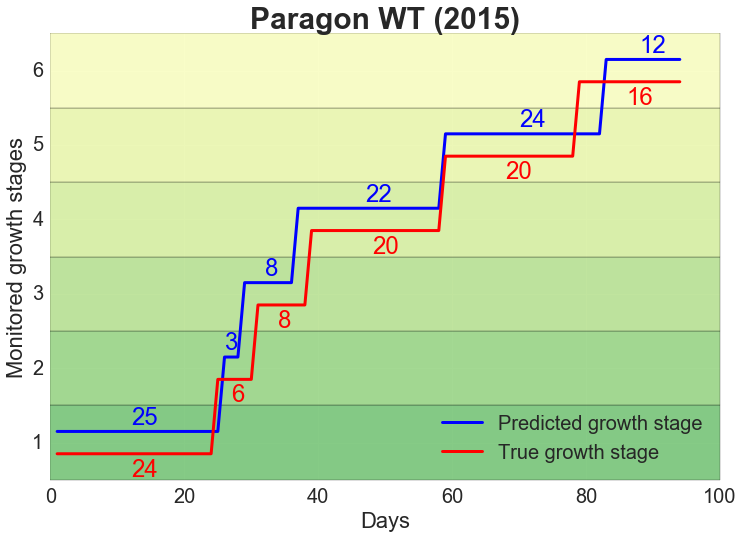

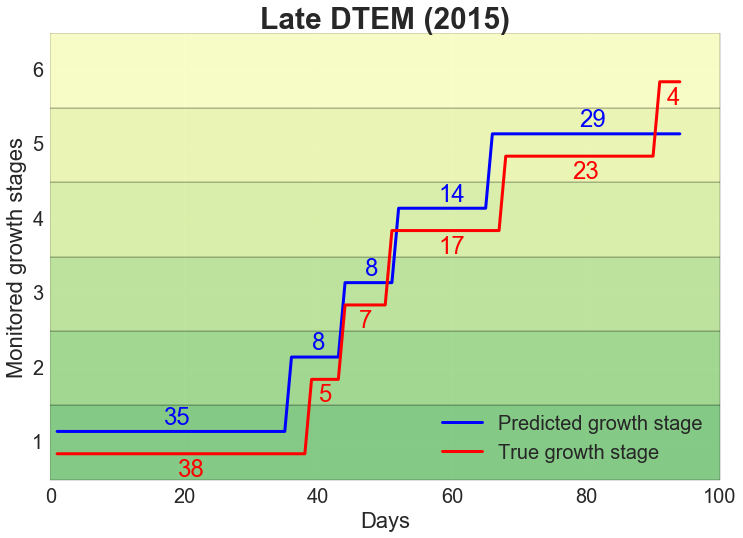

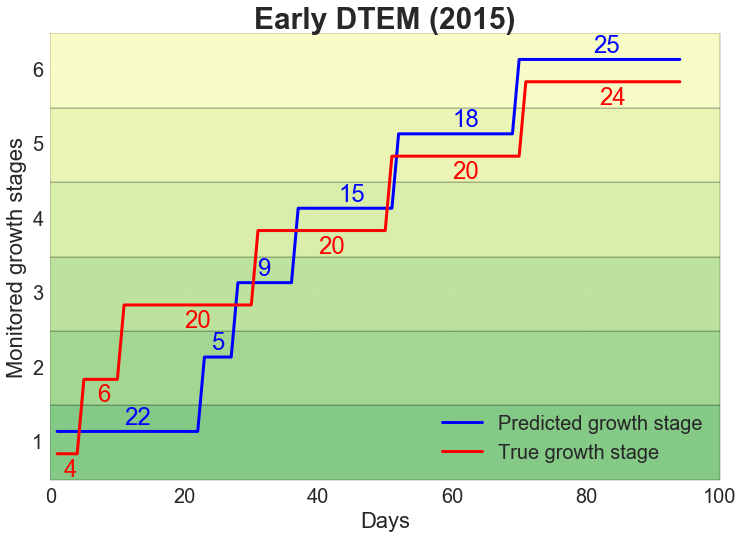

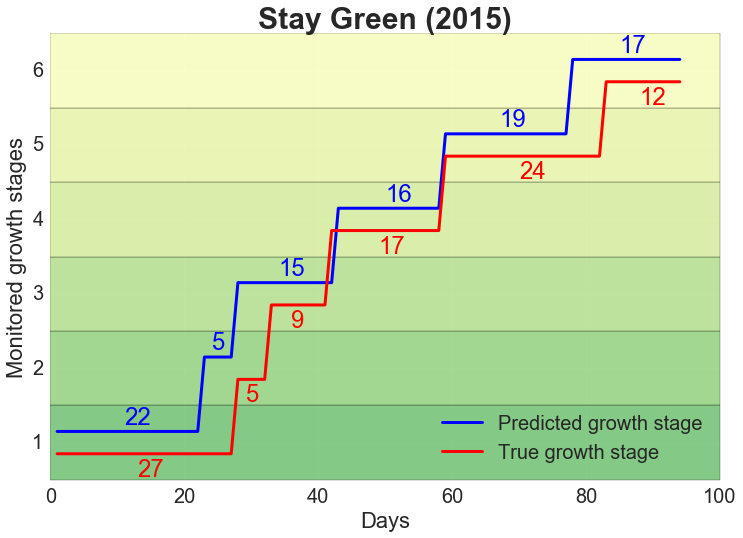

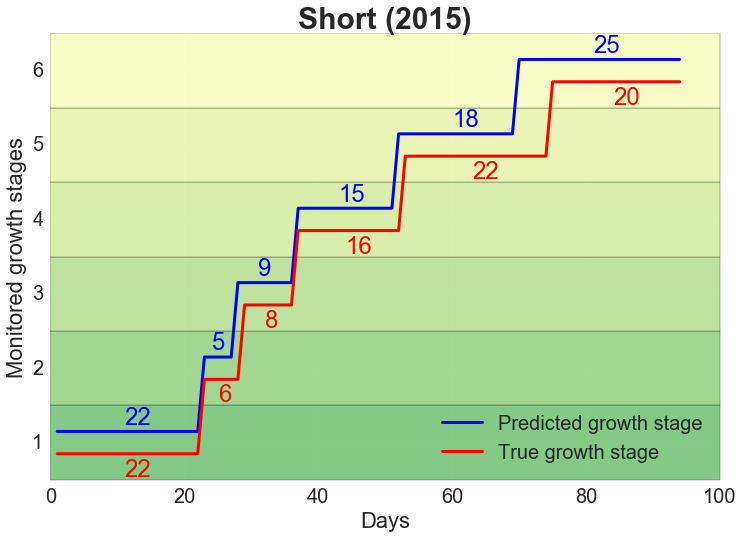

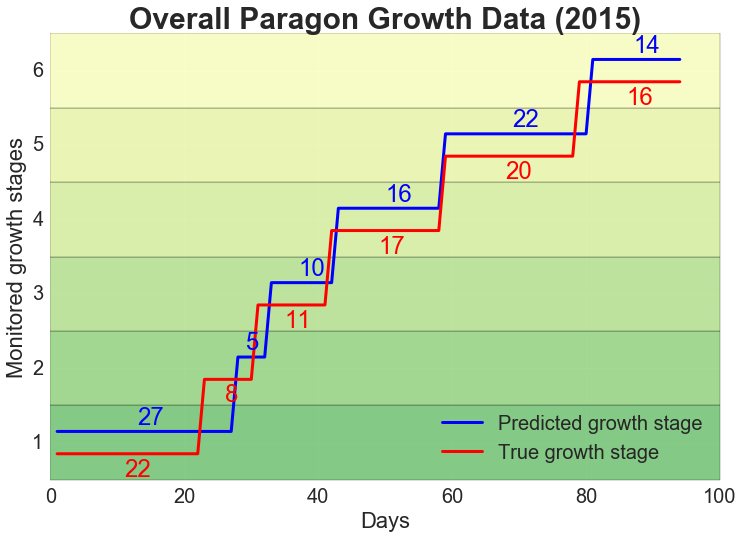

In [16]:
gen_names = ['Paragon WT (2015)', 'Late DTEM (2015)', 'Early DTEM (2015)', 'Stay Green (2015)', \
                                         'Short (2015)', 'Overall Paragon Growth Data (2015)']

genotypes = ['G1', 'G2', 'G3', 'G4', 'G5', 'GT']

#for each genotype
for k in range(6):
    #train with all other genotypes
    train = feats.loc[feats.Genotype != genotypes[k]]
    train_target = train['Grow_Stg']
    train_input = train.drop(train[['Grow_Stg', 'Genotype']], axis=1)

    #test with single genotype
    test = feats.loc[feats.Genotype == genotypes[k]]
    test_target = test['Grow_Stg']
    test_input = test.drop(test[['Grow_Stg', 'Genotype']], axis=1)
    #store predicted growth stages
    pred_gs = np.zeros(test_target.as_matrix().shape)
    
    #use KFold validation with test set
    kf = KFold(test_target.as_matrix().size ,n_folds=5, shuffle=True, random_state=42)
    for train_index, test_index in kf:
        X_train, X_test = test_input.as_matrix()[train_index], test_input.as_matrix()[test_index]
        y_train, y_test = test_target.as_matrix()[train_index], test_target.as_matrix()[test_index]

        #initialise classifier (SVM)
        clf = svm.SVC() 
        #train classifier
        clf.fit(np.vstack((train_input.as_matrix(), X_train)).astype('f'), \
                np.hstack((train_target.as_matrix(), y_train)).astype('f'))

        #predict growth stages for test set
        pred_gs[test_index] = clf.predict(X_test)

    #Smooth predicted growth stage curve
    pred_gs = SmoothPGS(pred_gs)
   
    #Plotting
    #Plot a figure of the modelled growth stages against the true growth stage
    plt.figure(figsize=(12,8))

    #Force the lines to be spaced vertically to aid readability when they overlap, IMO
    plt.plot(range(1, np.shape(test_input.as_matrix())[0]+1), (pred_gs +0.15).astype('f'), color='b', 
                                                     linewidth=3, label='Predicted growth stage')
    plt.plot(range(1, np.shape(test_input.as_matrix())[0]+1), (test_target.as_matrix() -0.15).astype('f'), color='r',
                                                     linewidth=3, label='True growth stage')
    #Add labels and adjust axis, add legend
    #plt.title('Modelling growth stages (GS), Paragon WT 2015', fontsize=30, weight='bold')
    plt.title(gen_names[k], fontsize=30, weight='bold')
    plt.ylabel('Monitored growth stages')
    plt.xlabel('Days')
    plt.axis([0, 100, 0.5, 6.5])
    plt.legend(loc='lower right')

    #Add colour bands of growth stages
    cols = cm.YlGn_r(np.linspace(0.5, 0.9, 6))
    alp = .9
    for i in range(0,6):
        plt.fill_between(range(0, 101), (0.5 + i), (1.5 + i), facecolor=cols[i], 
                                                         alpha=alp, interpolate=True)        
    #Annotating plot with duration of true growth stages
    for i in range(1,np.max(test_target.as_matrix())+1):
        #text for true growth, calculating growth stage durations
        start_lim = next(x[0] for x in enumerate(test_target.as_matrix()) if x[1] == i)
        end_lim = next(x[0] for x in enumerate(np.append(test_target.as_matrix(), \
                                                         [np.max(test_target.as_matrix())+1])) if x[1] == i+1)
        #the growth stage duration = end_lim - start_lim
        plt.text((np.floor((start_lim+end_lim)/2)), (i-0.45), end_lim-start_lim, color='r')
    
    #Annotating plot with duration of predicted growth stages
    for i in range(1, int(np.max(pred_gs)+1)):
        #text for predicted growth, calculating growth stage durations
        start_lim = next(x[0] for x in enumerate(pred_gs) if x[1] == i)
        end_lim = next(x[0] for x in enumerate(np.append(pred_gs, [np.max(pred_gs)+1])) if x[1] == i+1)
        #the growth stage duration = end_lim - start_lim
        plt.text((np.floor((end_lim+start_lim)/2)), (i+0.25), end_lim-start_lim, color='b')
        
    #plt.savefig('IMAGES/%s_2015.eps' % (genotypes[k]), format='eps', dpi=1000)

## Paragon WT 2015

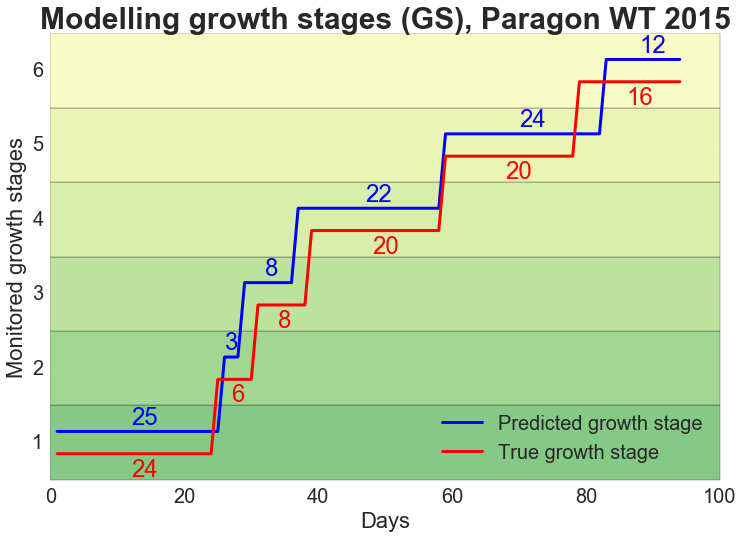

In [17]:
#Training features are all genotype data that is not 'G1', test with 'G1', only 2015

#train with all other genotypes
train = feats.loc[feats.Genotype != 'G1']
train_target = train['Grow_Stg']
train_input = train.drop(train[['Grow_Stg', 'Genotype']], axis=1)

#test with single genotype
test = feats.loc[feats.Genotype == 'G1']
test_target = test['Grow_Stg']
test_input = test.drop(test[['Grow_Stg', 'Genotype']], axis=1)

#store predicted growth stages
pred_gs = np.zeros(test_target.as_matrix().shape)

#use KFold validation with test set
kf = KFold(test_target.as_matrix().size ,n_folds=5, shuffle=True, random_state=42)
for train_index, test_index in kf:
    X_train, X_test = test_input.as_matrix()[train_index], test_input.as_matrix()[test_index]
    y_train, y_test = test_target.as_matrix()[train_index], test_target.as_matrix()[test_index]

    #initialise classifier (SVM)
    clf = svm.SVC() 

    #train classifier
    clf.fit(np.vstack((train_input.as_matrix(), X_train)).astype('f'), \
            np.hstack((train_target.as_matrix(), y_train)).astype('f'))

    #predict growth stages for test set
    pred_gs[test_index] = clf.predict(X_test)

#Smooth predicted growth stage curve
pred_gs = SmoothPGS(pred_gs)


#Plotting   
#Plot a figure of the modeled growth stages against the true growth stage
plt.figure(figsize=(12,8))

#Force the lines to be spaced vertically to aid readability when they overlap, IMO
plt.plot(range(1, np.shape(test_input.as_matrix())[0]+1), (pred_gs +0.15).astype('f'), color='b', 
                                                 linewidth=3, label='Predicted growth stage')
plt.plot(range(1, np.shape(test_input.as_matrix())[0]+1), (test_target.as_matrix() -0.15).astype('f'), color='r',
                                                 linewidth=3, label='True growth stage')

#Add labels and adjust axis, add legend
plt.title('Modelling growth stages (GS), Paragon WT 2015', fontsize=30, weight='bold')
plt.ylabel('Monitored growth stages')
plt.xlabel('Days')
plt.axis([0, 100, 0.5, 6.5])
plt.legend(loc='lower right')

#Add colour bands of growth stages
#cols = ['yellow', 'green', 'cyan', 'blue', 'magenta', 'red']
cols = cm.YlGn_r(np.linspace(0.5, 0.9, 6))
alp = .9
for i in range(0,6):
    plt.fill_between(range(0, 101), (0.5 + i), (1.5 + i), facecolor=cols[i], 
                                                     alpha=alp, interpolate=True)

#Annotating plot with duration of true growth stages
for i in range(1,np.max(test_target.as_matrix())+1):
    #text for true growth, calculating growth stage durations
    start_lim = next(x[0] for x in enumerate(test_target.as_matrix()) if x[1] == i)
    end_lim = next(x[0] for x in enumerate(np.append(test_target.as_matrix(), \
                                                     [np.max(test_target.as_matrix())+1])) if x[1] == i+1)
    #the growth stage duration = end_lim - start_lim
    plt.text((np.floor((start_lim+end_lim)/2)), (i-0.45), end_lim-start_lim, color='r')
    
#Annotating plot with duration of predicted growth stages
for i in range(1, int(np.max(pred_gs)+1)):
    #text for predicted growth, calculating growth stage durations
    start_lim = next(x[0] for x in enumerate(pred_gs) if x[1] == i)
    end_lim = next(x[0] for x in enumerate(np.append(pred_gs, [np.max(pred_gs)+1])) if x[1] == i+1)
    #the growth stage duration = end_lim - start_lim
    plt.text((np.floor((end_lim+start_lim)/2)), (i+0.25), end_lim-start_lim, color='b')
    
#plt.savefig('IMAGES/ParagonWT_2015.eps', format='eps', dpi=1000)

## Paragon WT 2016

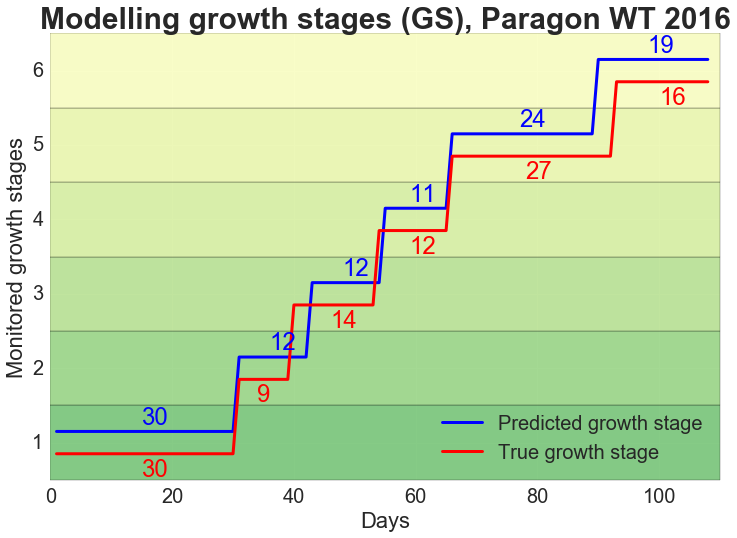

In [18]:
#Training features are all genotype data from 2015, test with 2016 'G1'

#train with all genotype data from 2015
train = feats.copy()
train_target = train['Grow_Stg']
train_input = train.drop(train[['Grow_Stg', 'Genotype']], axis=1)

#test with 2016 genotype data
test = nfeats.loc[nfeats.Genotype == 'G1']
test_target = test['Grow_Stg']
test_input = test.drop(test[['Grow_Stg', 'Genotype']], axis=1)

#store predicted growth stages
pred_gs = np.zeros(test_target.as_matrix().shape)

#use KFold validation with test set
kf = KFold(test_target.as_matrix().size ,n_folds=5, shuffle=True, random_state=42)
for train_index, test_index in kf:
    X_train, X_test = test_input.as_matrix()[train_index], test_input.as_matrix()[test_index]
    y_train, y_test = test_target.as_matrix()[train_index], test_target.as_matrix()[test_index]

    #initialise classifier (SVM)
    clf = svm.SVC() 
    #train classifier
    clf.fit(np.vstack((train_input.as_matrix(), X_train)).astype('f'), \
            np.hstack((train_target.as_matrix(), y_train)).astype('f'))
    #predict growth stages for test set
    pred_gs[test_index] = clf.predict(X_test)

#Smooth predicted growth stage curve
pred_gs = SmoothPGS(pred_gs)

#Plotting 
#Plot a figure of the modeled growth stages against the true growth stage
plt.figure(figsize=(12,8))

#Force the lines to be spaced vertically to aid readability when they overlap, IMO
plt.plot(range(1, np.shape(test_input.as_matrix())[0]+1), (pred_gs +0.15).astype('f'), color='b', 
                                                 linewidth=3, label='Predicted growth stage')
plt.plot(range(1, np.shape(test_input.as_matrix())[0]+1), (test_target.as_matrix() -0.15).astype('f'), color='r',
                                                 linewidth=3, label='True growth stage')
#Add labels and adjust axis, add legend
plt.title('Modelling growth stages (GS), Paragon WT 2016', fontsize=30, weight='bold')
plt.ylabel('Monitored growth stages')
plt.xlabel('Days')
plt.axis([0, 110, 0.5, 6.5])
plt.legend(loc='lower right')


#Add colour bands of growth stages
#cols = ['yellow', 'green', 'cyan', 'blue', 'magenta', 'red']
cols = cm.YlGn_r(np.linspace(0.5, 0.9, 6))
alp = .9
for i in range(0,6):
    plt.fill_between(range(0, 111), (0.5 + i), (1.5 + i), facecolor=cols[i], 
                                                     alpha=alp, interpolate=True)
    
#Annotating plot with duration of true growth stages
for i in range(1,np.max(test_target.as_matrix())+1):
    #text for true growth, calculating growth stage durations
    start_lim = next(x[0] for x in enumerate(test_target.as_matrix()) if x[1] == i)
    end_lim = next(x[0] for x in enumerate(np.append(test_target.as_matrix(), \
                                                     [np.max(test_target.as_matrix())+1])) if x[1] == i+1)
    #the growth stage duration = end_lim - start_lim
    plt.text((np.floor((start_lim+end_lim)/2)), (i-0.45), end_lim-start_lim, color='r')
    
#Annotating plot with duration of predicted growth stages
for i in range(1, int(np.max(pred_gs)+1)):
    #text for predicted growth, calculating growth stage durations
    start_lim = next(x[0] for x in enumerate(pred_gs) if x[1] == i)
    end_lim = next(x[0] for x in enumerate(np.append(pred_gs, [np.max(pred_gs)+1])) if x[1] == i+1)
    #the growth stage duration = end_lim - start_lim
    plt.text((np.floor((end_lim+start_lim)/2)), (i+0.25), end_lim-start_lim, color='b')
        
#plt.savefig('IMAGES/ParagonWT_2016.eps', format='eps', dpi=1000)

In [ ]:
###################################################################
#            END of the predictive growth modelling               #
###################################################################